[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2022/blob/main/sessions/gans/RSNA2022_DLL_GAN.ipynb)

# RSNA 2022 Deep Learning Lab: **Generative Adversarial Networks**

Presented by: Bradley J. Erickson, MD PhD<sup>\*</sup> <a href="https://twitter.com/Slowvak"><img width="16" src="https://i.ibb.co/J7Tpg3Q/twitter-logo-2429.png"></a>, Bardia Khosravi, MD MPH MHPE<sup>\*</sup> <a href="https://twitter.com/Khosravi_Bardia"><img width="16" src="https://i.ibb.co/J7Tpg3Q/twitter-logo-2429.png"></a>

\* *Mayo Clinic AI Lab, Department of Radiology, Mayo Clinic, Rochester, MN* <a href="https://twitter.com/MayoAILab"><img width="16" src="https://i.ibb.co/J7Tpg3Q/twitter-logo-2429.png"></a>

# 1. Introduction

Welcome to RSNA 2022 Deep Learning Lab on Generative Adversarial Networks (GANs). This workshop is designed in three sections:

1) **GANs in Action**: In this section, you will be getting familiar with the basics of GANs and will train GANs to create synthetic data 1D data.

2) **Medical Image Generation**: You will then use GANs to create synthetic chest x-rays and learn the overall training workflow of these models.

3) **Testing Our GAN**: Finally, you will see how you can condition a GAN to create images with specific characteristics, in our case presence of pneumonia, and explore some nuances of these models.

So without further ado, let's jump into the session content.

# 2. GANs in Action

GANs are essentially two networks competing with each other, hence the name adversarial. One tries to create fake images (the generator) and the other compares the generated images with real samples and gives feedback to the generator on how to improve fake images' quality. 

In [ ]:
#% cell 1 %#

import os
import random
import torch
import numpy as np
from tqdm.auto import tqdm
from scipy import signal
from ipywidgets import interactive, widgets, fixed

import matplotlib.pyplot as plt
%matplotlib inline

Due to computational constraints on Colab, we use a simple two-dimensional dataset. In this example, we try to train a GAN to approximate a sawtooth function as follows:

In [ ]:
#% cell 2 %#

def sawtooth_fn(x):
    y = signal.sawtooth(x, 0.5)
    return x, y

FUNCTION = sawtooth_fn

Let's plot to see what our function looks like:

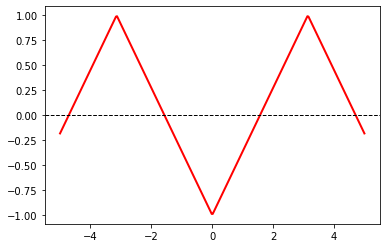

In [ ]:
#% cell 3 %#

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# we define min and max of the generated range
MIN_RANGE = -5
MAX_RANGE = 5

def plot_function(function):
    x = np.linspace(MIN_RANGE, MAX_RANGE, 300)
    x, y = function(x)
    plt.plot(x, y, 'r', linewidth=2)
    plt.axhline(0, color='black', linewidth=1, linestyle='--')

plot_function(FUNCTION)

We can now proceed with creating our networks:

In [ ]:
#% cell 4 %#

class Generator(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim//2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim//2, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim//2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim//2, output_dim),
        )
        
    def forward(self, x):
        return self.model(x)

class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim//2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim//2, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim//2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim//2, 1),
            torch.nn.Sigmoid() # binary output
        )
        
    def forward(self, x):
        return self.model(x)

You see that both the `Generator` and `Discriminator` classes have roughly the same architecture with two main differences:



1.  **Input Shape**: 

*   The input to the generator is a noise vector with the shape `(batch, latent_dim)`.
*   The input to the discriminator is a pair of numbers (x,y), resulting to a shape of `(batch, 2)`.


2.  **Output Shape**:

*   The generator outputs a pair of numbers, *just like the input of the discriminator*, with the shape `(batch, 2)`.
*   The output to the discriminator is a single number for each input showing how real an input pair is.

Now we can create our two networks and their optimizers:

In [ ]:
#% cell 5 %#

generator = Generator(latent_dim=10, hidden_dim=200, output_dim=2).to(DEVICE)
discriminator = Discriminator(input_dim=2, hidden_dim=100).to(DEVICE)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
loss_fn = torch.nn.BCELoss()

The following are some helper functions that we will use for this section:

In [ ]:
#% cell 6 %#

def seed_all(seed:int) -> None:
    """Seeds basic parameters for reproductibility of results.

    Args:
        seed (int): seed to use
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_real_data(batch_size:int) -> torch.Tensor:
    """get real data from the function

    Args:
        batch_size (int): number of samples

    Returns:
        torch.Tensor: batch of real data (batch_size, 2)
    """
    x = np.random.uniform(MIN_RANGE, MAX_RANGE, batch_size)
    x, y = FUNCTION(x)
    return torch.tensor(np.stack([x, y], axis=1), dtype=torch.float32)

def get_noise(batch_size: int, latent_dim:int) -> torch.Tensor:
    """_summary_

    Args:
        batch_size (int): number of samples
        latent_dim (int): latent dimension of the noise

    Returns:
        torch.Tensor: batch of noise (batch_size, latent_dim)
    """
    return torch.randn(batch_size, latent_dim)

def generate_fake_samples(generator:torch.nn.Module, num_samples:int) -> torch.Tensor:
    """generate fake samples from the generator

    Args:
        generator (torch.Module): generator model
        num_samples (int): number of samples

    Returns:
        torch.Tensor: batch of fake data (batch_size, 2)
    """
    generator.eval()
    noise = get_noise(num_samples, generator.latent_dim).to(DEVICE)
    with torch.no_grad():
        fake_data = generator(noise).detach().cpu().numpy()
    return fake_data

def plot_generated_data(synthetic_data:np.ndarray, title:str = "Generated Data"):
    """Plot the synthetic data and the original function.

    Args:
        synthetic_data (np.ndarray): synthetic data generated by the generator.
        title (str, optional): the title of the plot. Defaults to "Generated Data".
    """
    plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=4)
    plt.title(title)
    plot_function(FUNCTION)
    plt.show()

def plot_log_images(iteration: int, data_log:list) -> None:
    """Plot the generated data at a specific iteration.

    Args:
        iteration (int): iteration number
        data_log (list): list of the generated data at each iteration
    """
    idx = iteration//100
    plot_generated_data(data_log[idx], title=f"Iteration #{iteration}")
    plt.show()

The main training function for our GAN is:

In [ ]:
#% cell 7 %#

def train_gan(generator, discriminator, gen_optimizer, disc_optimizer, loss_fn, batch_size, train_iterations=10000) -> [list, list, list]:
    """Train the GAN model
    
    Args:
        generator (torch.nn.Module): generator model
        discriminator (torch.nn.Module): discriminator model
        gen_optimizer (torch.optim): generator optimizer
        disc_optimizer (torch.optim): discriminator optimizer
        loss_fn (torch.nn): loss function
        batch_size (int): batch size
        train_iterations (int, optional): number of training iterations. Defaults to 10000.

    Returns:
        gen_loss_history: list of generator losses
        disc_loss_history: list of discriminator losses
        data_log: list of generated data at each 100 iterations
    """
    disc_loss_history = []
    gen_loss_history = []
    data_log = []
    for iter in tqdm(range(train_iterations)):
        # Train discriminator
        disc_optimizer.zero_grad()
        real_data = get_real_data(batch_size).to(DEVICE)
        disc_real_pred = discriminator(real_data)
        disc_real_loss = loss_fn(disc_real_pred, torch.ones_like(disc_real_pred)) # real data should have label 1
        disc_real_loss.backward()
        
        noise = get_noise(batch_size, generator.latent_dim).to(DEVICE)
        fake_data = generator(noise)
        disc_fake_pred = discriminator(fake_data)
        disc_fake_loss = loss_fn(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # fake data should have label 0
        disc_fake_loss.backward()
        
        disc_loss = (disc_real_loss + disc_fake_loss)/2
        disc_loss_history.append(disc_loss.item())
        disc_optimizer.step()
        
        # Train generator
        gen_optimizer.zero_grad()
        noise = get_noise(batch_size, generator.latent_dim).to(DEVICE)
        fake_data = generator(noise)
        disc_fake_pred = discriminator(fake_data)
        gen_loss = loss_fn(disc_fake_pred, torch.ones_like(disc_fake_pred)) # generator wants discriminator to think fake data is real
        gen_loss.backward()
        gen_loss_history.append(gen_loss.item())
        gen_optimizer.step()

        if (iter+1)%100 == 0 or iter == 0:

            synthetic_samples = generate_fake_samples(generator, 1000)
            data_log.append(synthetic_samples)
        
    return gen_loss_history, disc_loss_history, data_log

Let's start training our GAN to see if it can approximate our original function.

In [ ]:
#% cell 7 %#

seed_all(10922)
gen_loss_history, disc_loss_history, data_log = train_gan(generator, discriminator, gen_optimizer, disc_optimizer, loss_fn, batch_size=100, train_iterations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

We can check our model's progress throughout the training:

In [ ]:
#% cell 8 %#

interactive_plot = interactive(
    plot_log_images,
    iteration=widgets.IntSlider(min=0, max=(len(data_log)-1)*100, step=100, value=0),
    data_log=fixed(data_log),
)
interactive_plot

interactive(children=(IntSlider(value=0, description='iteration', max=10000, step=100), Output()), _dom_classe…

Now let's try a more sophisticated function:

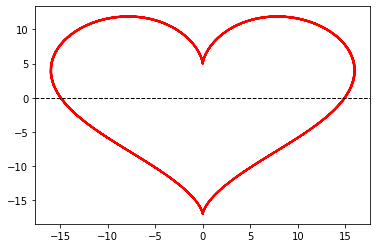

In [ ]:
#% cell 9 %#

MIN_RANGE = -15
MAX_RANGE = 15

def heart_fn(theta):
    x = 16 * (np.sin(theta) ** 3)
    y = 13 * np.cos(theta) - 5* np.cos(2*theta) - 2 * np.cos(3*theta) - np.cos(4*theta)

    return x,y

FUNCTION = heart_fn
plot_function(FUNCTION)

Will our GAN learn to approximate this function?

In [ ]:
#% cell 10 %#

generator = Generator(latent_dim=10, hidden_dim=200, output_dim=2).to(DEVICE)
discriminator = Discriminator(input_dim=2, hidden_dim=100).to(DEVICE)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
loss_fn = torch.nn.BCELoss()

seed_all(10922)
gen_loss_history, disc_loss_history, data_log = train_gan(generator, discriminator, gen_optimizer, disc_optimizer, loss_fn, batch_size=100, train_iterations=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]



<font size="3" color="red"><b>Question:</b></font> How is this different than a supervised model?

<details>

<summary>
<font size="3" color="green">
<b>Answer: <font size="2" color="orange"><i>Click here to see if your answer is correct.<i></font></b>
</font>
</summary>
 
In a supervised task, the model will get an input and try to generate an output that is compared with a ground truth; in other words, the model will get `x` and then try to find out the corresponding `y`. However, for the GAN training, tho model generated *pairs* of `x,y` and the generator validates these pairs.
</details>



Now, let's see how our model tackled this problem.

In [ ]:
#% cell 11 %#

interactive_plot = interactive(
    plot_log_images,
    iteration=widgets.IntSlider(min=0, max=(len(data_log)-1)*100, step=100, value=0),
    data_log=fixed(data_log),
)
interactive_plot

interactive(children=(IntSlider(value=0, description='iteration', max=20000, step=100), Output()), _dom_classe…

This is a very good performance for only three linear layers, highlighting the power of the discriminator's feedback in shaping the generator's output.

# 3. Medical Image Generation


In this section, we will use a dataset from [Kermany et al.](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810), comprising of 5,000 pediatric chest x-rays with three class labels:

- Normal
- Bacterial Pneumonia
- Viral Pneumonia

By the end of this section, we will know how to train a StyleGAN model that can ultimately generate pediatric chest radiographs. 

We first need to download the dataset:


In [1]:
#% cell 12 %#

import gdown
import os

if not os.path.isdir("workshop_data"):
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1bU-lLDAYZRPTJpaYfrATA7JJ8gwA3HwM",
        "workshop_data.zip",
        quiet=False,
    )
    !mkdir "workshop_data"
    !unzip -q "workshop_data.zip" -d "workshop_data"
    os.remove("workshop_data.zip")

    !mkdir "workshop_data/Original_Dataset"
    !unzip -q "workshop_data/Kermany_Dataset.zip" -d "workshop_data/Original_Dataset"
    os.remove("workshop_data/Kermany_Dataset.zip")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1bU-lLDAYZRPTJpaYfrATA7JJ8gwA3HwM
To: /content/workshop_data.zip
100%|██████████| 1.58G/1.58G [00:26<00:00, 59.5MB/s]


Let's clone the StyleGAN codebase and install some requirements.

In [2]:
#% cell 13 %#

import os

if not os.path.exists("stylegan3"):
    !git clone https://github.com/BardiaKh/stylegan3.git # a fork that is compatible with latest pytorch
    !pip install ninja
    !pip install imageio-ffmpeg
else:
    print("Requirements are already installed.")

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 7.88 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 34.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.3 MB/s 


StyleGAN codebase has tools that automate dataset preparation, training, validation, and much more. Due to the current workshop's time limits, we have prepared the dataset for training the model, however, if you are interested, you can take a look at the details in the next box.

In [ ]:
# @title Optional: Dataset preprocessing
# @markdown You can double-click this cell to see the code that takes care of pre-processing the data and optimizing it for StyleGAN training.

# @markdown **DO NOT** run this cell during the workshop as it will take about 20 minutes to complete.

prompt = input("Are you sure you want to run this cell during the workshop? [y/n] ")
if prompt.lower() not in ["y", "yes"]:
    raise KeyboardInterrupt

# Imports
import json
import torch
from glob import glob
from tqdm import tqdm
from skimage import io
from skimage.transform import resize
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from concurrent.futures import ProcessPoolExecutor

# Path to save the data
ORIGINAL_DATA_PATH = '/content/workshop_data/Original_Dataset'
SAVE_DIR = f"/content/workshop_data/gan_raw_data"
os.makedirs(f"{SAVE_DIR}/imgs", exist_ok=True)

# Reading all images with their label and saving to a list of dictionaries
files = glob(f"{ORIGINAL_DATA_PATH}/chest_xray/*/*/*.jpeg")
DATA_DICT = []
for file in files:
    label = file.split("/")[-2]
    if label == "NORMAL":
        label = 0
    else:
        if "virus" in file:
            label = 1
        else:
            label = 2
    label = torch.nn.functional.one_hot(torch.tensor(label), num_classes=3).numpy().tolist()
    DATA_DICT.append({"path": file, "label": label})

# Function to read and resize the image
def process_single_image(i):
    global DATA_DICT
    global SAVE_DIR
    item = DATA_DICT[i]
    name = item["path"].split("/")[-1].split(".")[0]
    filepath = f"imgs/{name}.png"
    
    image = io.imread(item["path"])
    if len(image.shape) == 3:
        image = rgb2gray(image)

    image = img_as_ubyte(image)
    io.imsave(f"{SAVE_DIR}/{filepath}",image)
    
    return [filepath, label]

# Multiprocessing to speed up the process
with ProcessPoolExecutor(max_workers=4) as executor:
    results = list(tqdm(executor.map(process_single_image, list(range(len(DATA_DICT)))), total=len(DATA_DICT)))

# Saving the corresponding labels to a json file
labels_json = {"labels": results}

with open(f'{SAVE_DIR}/dataset.json', 'w') as f:
    json.dump(labels_json, f)

# You can specify the training resolution here
IMAGE_SIZE = 64

# Running the stylegan data preparation script
%cd ./stylegan3
!python dataset_tool.py --source {SAVE_DIR} \
                        --dest {SAVE_DIR}/../pneumonia_three_class_{IMAGE_SIZE}.zip \
                        --resolution {IMAGE_SIZE}x{IMAGE_SIZE}
%cd ../

Now that we have our data ready, we need to run our training script. It will take 10-15 minutes to compile CUDA kernels for the first time. We have configured the model to run only on 5000 images. Training it for longer needs more time and more powerful accelerators.

The model's outputs (including the weights and intermediary examples) are stored in the `/outputs` folder.

In [ ]:
#% cell 14 %#

%cd stylegan3

DATASET_DIR = "/content/workshop_data/pneumonia_three_class_64.zip" # Training Data Path
KIMG = 4         # Number of images to train (in kilo-images)
METRICS = "None" # You can change to "fid50k_full"

!python train.py --outdir=/content/outputs --cfg=stylegan3-t --data={DATASET_DIR} --kimg={KIMG} --seed=10922 --gpus=1 --batch=32 --gamma=8.2 --mirror=1 --tick=1 --snap=4 --metrics=None

%cd ../

/content/stylegan3

Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 32768,
    "channel_max": 512,
    "magnitude_ema_beta": 0.9988915792636801
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 8.2
  },
  "data_loader_kwargs": {
    "pin_memory": true,

# 4. Testing Our GAN

Now that you know the basics of training a StyleGAN, we can go a step further and condition the generator based on some class labels. In other words, during training, the discriminator takes both the generated image (by the generator) and the class label into account to decide whether it is real vs. fake.

There are two things that you need to have a conditional StyleGAN:



1.   Having a `dataset.json` file in your dataset directory. (We have created this file in the above code snippet for dataset processing)
2.   Passing the flag `--cond=True` in the training script, for example:

```python
!python train.py --outdir=/content/outputs --cfg=stylegan3-t --data={DATASET_DIR} --kimg={KIMG} --cond=True

```

We have trained a conditional StyleGAN on 256x256 pixel radiographs from the same pediatric radiograph dataset. The trained weights are stored in `256_styleganv3t_7M.pkl` file.

Let's see how our conditional model works:

/content/stylegan3
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


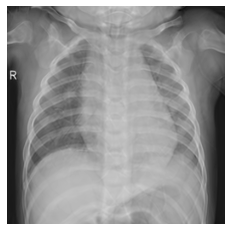

In [3]:
#@title Generate Conditional Samples

%cd "/content/stylegan3"

class_label = "Normal" #@param ["Normal", "Viral Pneumonia", "Bacterial Pneumonia"]

import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

with open('/content/workshop_data/256_styleganv3t_7M.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(DEVICE)

z = torch.randn([1, G.z_dim]).to(DEVICE)    # noise vector
psi = 0.7
c = {"Normal":0, "Viral Pneumonia":1, "Bacterial Pneumonia":2}[class_label]
c = torch.nn.functional.one_hot(torch.tensor(c), num_classes=3)
c = c.float().unsqueeze(0).to(DEVICE)
img = G(z, c, psi).detach().cpu()
plt.imshow(img[0,0], cmap='gray');
plt.axis('off');



<font size="3" color="red"><b>Question:</b></font> What do you think is wrong with the viral pneumonia images?

<details>

<summary>
<font size="3" color="green">
<b>Answer: <font size="2" color="orange"><i>Generate some samples with the simple GUI, then click here to see if your answer is correct.<i></font></b>
</font>
</summary>
 
The conditioned examples, especially with the viral pneumonia cases, could be more accurate, meaning that the model could not understand this class accurately. This is a common phenomenon in GAN training called *mode collapse*, meaning that one class, usually the minority, is not learned by the generator. Instead, the generator tries to excel at generating realistic examples from other classes.

</details>

Now, for the final step, let's visualize the latent space of the model. This is achieved by creating an interpolation video that generates multiple intermediary images between two noise vectors. Usually with GANs, this learned latent space is very smooth, resulting in a smooth morphing video.

In [ ]:
#@title Interpolation Video

%cd "/content/stylegan3"

#@markdown Please select start and end seed. It is recommended to set your `end_seed` to be equal to `start_seed + 10` to have a 20 second video generated in ~60 seconds.

class_label = "Normal" #@@param ["Normal", "Viral Pneumonia", "Bacterial Pneumonia"]
start_seed = 10 #@param {type:"number"}
end_seed = 20 #@param {type:"integer"}

import pickle
import torch
import imageio
import scipy
import numpy as np
from tqdm import tqdm
from IPython.display import HTML
from base64 import b64encode
 
def gen_interp_video(G, seeds, c=0):
    wraps = 2
    w_frames = 120
    seeds = list(seeds)
    num_keyframes = len(seeds)

    all_seeds = np.zeros(num_keyframes, dtype=np.int64)
    for idx in range(num_keyframes):
        all_seeds[idx] = seeds[idx % len(seeds)]

    zs = torch.from_numpy(np.stack([np.random.RandomState(seed).randn(G.z_dim) for seed in all_seeds])).to(DEVICE)
    c = c.repeat(len(all_seeds),1).to(DEVICE)
    ws = G.mapping(z=zs, c=c, truncation_psi=0.7)
    _ = G.synthesis(ws[:1]) # warm up
    ws = ws.reshape(num_keyframes, *ws.shape[1:])

    # Interpolation.
    x = np.arange(-num_keyframes * wraps, num_keyframes * (wraps + 1))
    y = np.tile(ws.cpu().numpy(), [wraps * 2 + 1, 1, 1])
    interp = scipy.interpolate.interp1d(x, y, kind='cubic', axis=0)

    # Render video.
    video_out = imageio.get_writer("demo.mp4", mode='I', fps=60, codec='libx264')
    imgs = []
    for frame_idx in tqdm(range(num_keyframes * w_frames)):
        w = torch.from_numpy(interp(frame_idx / w_frames)).to(DEVICE)
        img = G.synthesis(ws=w.unsqueeze(0), noise_mode='const')[0]
        img = (img+1)*127.5
        img = img.to(torch.uint8).cpu().numpy()
        img = img.transpose(1,2,0)
        video_out.append_data(img)
    video_out.close()

def show_video(video_path, video_width = 256):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

# Start from here

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

with open('/content/workshop_data/256_styleganv3t_7M.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(DEVICE)

c = {"Normal":0, "Viral Pneumonia":1, "Bacterial Pneumonia":2}[class_label]
c = torch.nn.functional.one_hot(torch.tensor(c), num_classes=3)
c = c.float().unsqueeze(0).to(DEVICE)

gen_interp_video(G, range(start_seed,end_seed), c)

show_video("demo.mp4")


/content/stylegan3


100%|██████████| 1200/1200 [01:02<00:00, 19.15it/s]


# 5. Future Reading

Here are some resources that will help you with learning more about the different type of GANs, details on their training, and some of their failure modes:



*   [Sharon Zhou's GAN Course](https://www.coursera.org/specializations/generative-adversarial-networks-gans): This specialization on Coursera starts from the basics of GANs and continues the discussion to more advanced topics.
*  [Original StyleGAN Paper](https://arxiv.org/abs/1812.04948): This is the first version of StyleGAN, the predecessor to the version that we used in this workshop.
*  [StyleGANv3 Paper](https://arxiv.org/abs/2106.12423): This paper goes into novelties of the latest version of StyleGAN, the one that we used in this workshop.
*  [MIDEL](https://midel.org/): Medical Imaging and Deep LEarning (MIDEL), is a free learning resource developed by Mayo Clinic AI Lab, helping healthcare professionals get familiar with deep learning concepts.